<a href="https://colab.research.google.com/github/charlielu05/kalman_filter/blob/master/Kalman_Filter_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hugh's Python Implementation

In [12]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pandas as pd 

Code to generate simulation

In [ ]:
# Simulation of x
def xtrue(F,G,Q,x0,dt,tsteps):
    
    # set up the state vector as a 3d array
    dims=np.shape(x0)
    xdim=dims[0]
    x=np.zeros((tsteps,xdim,1))
    x[0]=x0
    # simulation
    for i in range(tsteps-1):
        noise=rd.gauss(0,Q)
        x[i+1]=F@x[i]+G@np.array([[noise]])
        
    return(x)
#
# simulation of z
def obs(x,H,R):
    dims=np.shape(x)
    tsteps=dims[0]
    dims=np.shape([H])
    zdim=dims[0]
    z=np.zeros((tsteps,zdim,1))
    
    # simulation
    for i in range(tsteps):
        noise=rd.gauss(0,R)
        z[i]=H@x[i]+noise
        
    return(z)

In [5]:
# a fix because python does not do edge cases
def myminv(A):
    if np.size(A) == 1:
        return (1/A)
    else:
        return inv(A)
    
# Main linear Kalman Filter
# All in one file
def lkf(F,G,H,B,sigmaq,sigmar,zt,x0):
    # first set up some space
    dims=np.shape(zt)
    tsteps=dims[0]
    zsize=dims[1]
    dims=np.shape(F)
    xsize=dims[0]
    xest=np.zeros((tsteps,xsize,1))
    xpred=np.zeros((tsteps,xsize,1))
    innov=np.zeros((tsteps,zsize,1))
    Pest=np.zeros((tsteps,xsize,xsize))
    Ppred=np.zeros((tsteps,xsize,xsize))
    S=np.zeros((tsteps,zsize,zsize))
    #
    # some useful matrices - used multiple times
    FT=np.transpose(F)
    HT=np.transpose([H]) # why is this double bracket necessary?
    #
    # now initialise
    Q=np.array([[sigmaq*sigmaq]])
    R=np.array([[sigmar*sigmar]])
    Qm=G@Q@np.transpose(G)
    Rm=B@R@np.transpose(B)
    xest[0]=x0
    Pest[0]=10*Qm
    xpred[0]=x0
    Ppred[0]=10*Qm
    
    # now main LKF loop
    for i in range(tsteps-1):
        # first do prediction and prediction covariance
        xpred[i+1]=F@xest[i]
        Ppred[i+1]=F@Pest[i]@FT + Qm 
        # then predicted observation, innovation and innovation covariance
        innov[i+1]=zt[i+1]-H@xpred[i+1]
        S=H@Ppred[i+1]@HT + Rm
        S=np.array([S]) # a mystery why this is required
        # then compute gain matrix
        SI=myminv(S)
        #SI=np.array([SI]) # a mystery why this is required
        Wgain=Ppred[i+1]@HT@SI
        # and finally update estimates
        xest[i+1]=xpred[i+1]+Wgain@innov[i+1]
        Pest[i+1]=Ppred[i+1]-Wgain@S@Wgain.T
    
    #
    # finally return results to be plotted
    return(xest,Pest,xpred,Ppred,innov,S)
    
def plot_true(x,z,xest,xpred,dt):
  dims=np.shape(x)
  tsteps=dims[0]
  t=np.linspace(0,dt*tsteps,tsteps)
  fig, ax = plt.subplots()
  ax.plot(t, x[:,0,0], label='Xtrue')
  ax.plot(t, z[:,0,0], label='Ztrue')
  ax.plot(t, xest[:,0,0], label='Xest')
  ax.plot(t, xpred[:,0,0], label='Xpred')
  ax.set_xlabel('Time')
  ax.set_ylabel('Position')
  ax.set_title("True Motion and Observations")
  ax.legend()

Setup the variables

In [133]:
nt=100
dt=0.1
F=np.array([[1,dt],[0,1]])
G=np.array([[dt*dt/2],[dt]])
H=np.array([1.0,0])
B=np.array([1.0])
qstd=0.1
rstd=0.1
x0=np.array([[0],[0]])

# simulate
xt=xtrue(F,G,qstd,x0,dt,nt)
zt=obs(xt,H,rstd)
# estimate
xest,hugh_Pest,hugh_xpred,hugh_Ppred,dz,S=lkf(F,G,H,B,qstd,rstd,zt,x0)

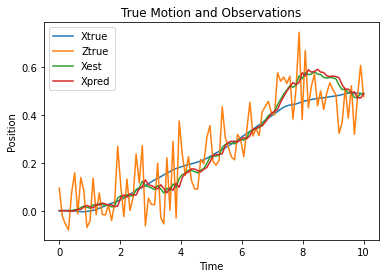

In [134]:
#plot
plot_true(xt,zt,xest,hugh_xpred,dt)

---

### Python Class Implementation

In [147]:
class KF_MODEL:
    def __init__(self, n_features, qstd, rstd, x0, G, B, F, independent=False):
        self.Q = np.array([[qstd*qstd]])
        if independent:
            self.Qm = np.eye(n_features) * self.Q
        else:
            self.Qm = G@self.Q@np.transpose(G)
        self.Pest = np.ones((n_features,n_features)) * self.Qm * 10
        self.Rm = B @ np.array([[rstd * rstd]]) @ B.T
        self.xest = x0
        self.F = F
        self.xpred = x0
        self.Ppred = 10 * self.Qm
    
    def prediction_step(self):
        xpred = self.F @ self.xest
        Ppred = self.F @ self.Pest @ self.F.T + self.Qm 
        
        self.xpred = xpred
        self.Ppred = Ppred
        
        return self
    
    def filter_step(self, zt, H):
        innov = zt - H @ self.xpred
        S = H @ self.Ppred @ H.T + self.Rm
        SI = np.linalg.inv(S)
        Wgain = self.Ppred @ H.T @ SI
        
        self.S = S
        self.innov = innov
        self.Wgain = Wgain
  
        return self
    
    def update_step(self):
        xest = self.xpred + self.Wgain @ self.innov
        Pest = self.Ppred - self.Wgain @ np.outer(self.S, self.Wgain.T)

        self.xest = xest
        self.Pest = Pest
        
        return self

Initialize the Kalman Filter object

In [148]:
kf = KF_MODEL(2, qstd, rstd, x0, G, B, F)

Putting the true state and observation into a dataframe

In [136]:
x_true_df = pd.DataFrame(xt[:,:,0], columns=['velocity', 'acceleration'])

In [137]:
z_observations_df = pd.DataFrame(zt[:,:,0], columns=['position'])

Iterate and append results into a list

In [149]:
xest = []
Pest = []
xpred = []
y_true = []
y_pred = []

xpred.append(x0)

for _,row in z_observations_df.iterrows():

    # Prediction
    kf.prediction_step()    
    kf_prediction = kf.xpred
    xpred.append(kf_prediction)

    # Filter & Update
    H = np.array([[1.,0]])
    kf.filter_step(row[0], H)
    kf.update_step()
    xest.append(kf.xest)
    Pest.append(kf.Pest)

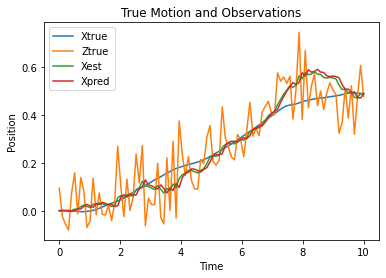

In [152]:
plot_true(xt,zt,np.asarray(xest),np.asarray(xpred[1:]),dt)